In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation 
%matplotlib inline
import time, sys
from scipy.sparse import spdiags
from scipy import sparse
from scipy.sparse.linalg import spsolve
import pickle

In [2]:
# load FOM solution
u=pickle.load(open("./data/FOM.p",'rb'))
u_fom=u[1:,:-1]
u_ref=u[0,:-1]

# nparam
nparamArr_LSROM=np.array([2,4,6,8,10])

# avg. rel. errors
relErr_LSROM_g=np.zeros(nparamArr_LSROM.shape)
relErr_LSROM_lspg=np.zeros(nparamArr_LSROM.shape)

# max. rel. errors
maxErr_LSROM_g=np.zeros(nparamArr_LSROM.shape)
maxErr_LSROM_lspg=np.zeros(nparamArr_LSROM.shape)

# proj. errors
proErr_LSROM=np.zeros(nparamArr_LSROM.shape)
for ii in range(len(nparamArr_LSROM)):
    nparam=nparamArr_LSROM[ii]
    
    # load POD basis
    file_name_POD="./model/POD_v2_nparam_{}.p".format(nparam)

    POD = pickle.load(open(file_name_POD,'rb'))

    phi=np.copy(POD)
    phiT=phi.T

    proj=(np.eye(u_fom.shape[1])-phi.dot(phiT)).dot((u_fom-u_ref).T)
    pro_err=np.sqrt(np.sum(np.linalg.norm(proj,ord=2,axis=0)**2))/np.sqrt(np.sum(np.linalg.norm(u_fom,ord=2,axis=1)**2))*100
    proErr_LSROM[ii]=pro_err

# LS-ROM (g) ~ $O(f^2m)$, where $f$ is a latent dimension

In [3]:
for ii in range(len(nparamArr_LSROM)):
    nparam=nparamArr_LSROM[ii]
    
    # load POD basis
    file_name_POD="./model/POD_v2_nparam_{}.p".format(nparam)

    POD = pickle.load(open(file_name_POD,'rb'))

    phi=np.copy(POD)
    phiT=phi.T

    POD_basis =phi.shape[1]

    def sine_wave(amp,width,nx,dx,x):

        u0 = np.zeros(nx) + 1.0
        u0[1:int(width/dx+1)] = 1.0 + amp/2*(np.sin(2*np.pi/(x[int(width/dx+1)]-x[1])*x[1:int(width/dx+1)]-np.pi/2)+1)
        u0[-1] = u0[0]

        return u0

    def residual_hat(u_hatn,u_hatw,uw,c,phiT,idxn1):

        # \hat r = -\hat u^n + \hat u^{n+1} - dt*\phi^T f(\phi \hat u^{n+1})   

        f = c*(uw**2 - uw*uw[idxn1]) 

        r_hat = -u_hatn + u_hatw + phiT.dot(f)

        return r_hat

    def jacobian_hat(u,c,phiT,phi,idxn1,I_hat):

        # \hat J = \hat I - dt \phi^T Jf \phi

        diag_comp = c*(2*u - u[idxn1])
        diag_out = diag_comp*phiT

        subdiag_comp = -c*u[1:]
        subdiag_out = subdiag_comp*phiT[:,1:]

        last_col = -c*u[0]*phiT[:,0]

        phiTJf = diag_out
        phiTJf[:,:-1] += subdiag_out
        phiTJf[:,-1] += last_col

        J_hat = I_hat + phiTJf.dot(phi)

        return J_hat

    amp = 1.0
    width = 1.0

    convergence_threshold = 1.0e-8
    maxk = 4

    nx = 1001
    dx = 2.0 / (nx - 1)
    nt = 501  
    dt = 0.5 / (nt - 1)   

    c = dt/dx

    x = np.linspace(0, 2, nx)

    idxn1 = np.zeros(nx-1,dtype='int')
    idxn1[1:] = np.arange(nx-2)
    idxn1[0] = nx-2

    u0 = sine_wave(amp,width,nx,dx,x)
    u_hat0 = np.zeros(POD_basis)

    t_total_rom_g_start=time.time()

    u_rom_g = np.zeros((nt,nx))
    u_rom_g[0] = u0
    u_hat = np.zeros((nt,POD_basis))
    u_hat[0] = u_hat0
    I_hat = np.eye(POD_basis)

    for n in range(nt-1): 
    #     print("")
    #     print(n,"th time step:")

        u_hatw = u_hat[n].copy()

        uw = u0[:-1] + phi.dot(u_hatw)

        r_hat = residual_hat(u_hat[n],u_hatw,uw,c,phiT,idxn1)

        for k in range(maxk):   
            J_hat = jacobian_hat(uw,c,phiT,phi,idxn1,I_hat)

            du_hatw = np.linalg.solve(J_hat,-r_hat) 

            u_hatw = u_hatw + du_hatw

            uw = u0[:-1] + phi.dot(u_hatw)

            r_hat = residual_hat(u_hat[n],u_hatw,uw,c,phiT,idxn1)

            res = np.linalg.norm(r_hat)      
    #         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))        

            if res < convergence_threshold:
                u_hat[n+1] = u_hatw.copy()
                u_rom_g[n+1,:-1] = uw.copy()
                u_rom_g[n+1,-1] = u_rom_g[n+1,0]    
                break

        if res >= convergence_threshold:
            print("\n non converged after {}th iteration".format(maxk))
            break

    #     u_hat[n+1] = u_hatw.copy()
    #     u_rom_g[n+1,:-1] = uw.copy()
    #     u_rom_g[n+1,-1] = u_rom_g[n+1,0]

    t_total_rom_g=time.time()-t_total_rom_g_start
    print()
    print("Time elapsed: {} sec".format(t_total_rom_g))

    rel_err=np.linalg.norm(u-u_rom_g,axis=1)/np.linalg.norm(u,axis=1)*100
    avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_g,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
    max_rel_err = np.max(rel_err)
    print()
    print("Average relative error: {} %".format(avg_rel_err))
    print("Maximum relative error: {} %".format(max_rel_err))
    
    relErr_LSROM_g[ii]=avg_rel_err
    maxErr_LSROM_g[ii]=max_rel_err


Time elapsed: 0.2011127471923828 sec

Average relative error: 3.6002366368064136 %
Maximum relative error: 6.196377107540694 %

Time elapsed: 0.17660236358642578 sec

Average relative error: 3.5734204675729693 %
Maximum relative error: 6.525345994329482 %

Time elapsed: 0.164351224899292 sec

Average relative error: 3.567102130236629 %
Maximum relative error: 6.634358296810216 %

Time elapsed: 0.16253995895385742 sec

Average relative error: 3.564357115512104 %
Maximum relative error: 6.687513146503969 %

Time elapsed: 0.16333389282226562 sec

Average relative error: 3.5628329972247372 %
Maximum relative error: 6.718847110872191 %


# LS-ROM (lspg) ~ $O(f^2m)$

In [4]:
for ii in range(len(nparamArr_LSROM)):
    nparam=nparamArr_LSROM[ii]
    
    # load POD basis
    file_name_POD="./model/POD_v2_nparam_{}.p".format(nparam)

    POD = pickle.load(open(file_name_POD,'rb'))

    phi=np.copy(POD)
    phiT=phi.T

    POD_basis =phi.shape[1]

    def sine_wave(amp,width,nx,dx,x):

        u0 = np.zeros(nx) + 1.0
        u0[1:int(width/dx+1)] = 1.0 + amp/2*(np.sin(2*np.pi/(x[int(width/dx+1)]-x[1])*x[1:int(width/dx+1)]-np.pi/2)+1)
        u0[-1] = u0[0]

        return u0

    def residual_lspg(uwn,uw,c,idxn1):

        f = c*(uw**2 - uw*uw[idxn1])

        r = -uwn + uw + f

        return r

    def jacobian_lspg(u,c,phiT,idxn1):

        # J \approx \phi - \Delta t J_f \phi = (I-\Delta t J_f) \phi

        diag_comp = 1.0 + c*(2*u - u[idxn1])
        diag_out = (diag_comp*phiT).T

        subdiag_comp = -c*u[1:]
        subdiag_out = (subdiag_comp*phiT[:,:-1]).T

        top_row = -c*u[0]*phiT[:,-1]

        J = diag_out
        J[1:] += subdiag_out
        J[0] += top_row

        return J

    amp = 1.0
    width = 1.0

    convergence_threshold = 1.0e-8
    maxk = 4

    nx = 1001
    dx = 2.0 / (nx - 1)
    nt = 501 
    dt = 0.5 / (nt - 1)  

    c = dt/dx

    x = np.linspace(0, 2, nx)

    idxn1=np.zeros(nx-1,dtype='int')
    idxn1[1:]=np.arange(nx-2)
    idxn1[0]=nx-2

    u0 = sine_wave(amp,width,nx,dx,x)
    u_hat0 = np.zeros(POD_basis,dtype='float32')

    t_total_rom_lspg_start=time.time()

    u_rom_lspg = np.zeros((nt,nx))
    u_rom_lspg[0] = u0
    u_hat = np.zeros((nt,POD_basis))
    u_hat[0] = u_hat0
    I_hat = np.eye(POD_basis)

    for n in range(nt-1): 
    #     print("")
    #     print(n,"th time step:")

        u_hatw = u_hat[n].copy()

        uw = u0[:-1] + phi.dot(u_hatw)

        J_lspg = jacobian_lspg(uw,c,phiT,idxn1)

        r_lspg = residual_lspg(u_rom_lspg[n,:-1],uw,c,idxn1)
        r = r_lspg.dot(J_lspg)

        for k in range(maxk):   
            J = J_lspg.T.dot(J_lspg)

            du_hatw = np.linalg.solve(J,-r)

            u_hatw = u_hatw + du_hatw

            uw = u0[:-1] + phi.dot(u_hatw)

            J_lspg = jacobian_lspg(uw,c,phiT,idxn1)

            r_lspg = residual_lspg(u_rom_lspg[n,:-1],uw,c,idxn1)
            r = r_lspg.dot(J_lspg)

            res = np.linalg.norm(r)
    #         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))

            if res < convergence_threshold:
                u_hat[n+1] = u_hatw.copy()
                u_rom_lspg[n+1,:-1] = uw.copy()
                u_rom_lspg[n+1,-1] = u_rom_lspg[n+1,0] 
                break

        if res >= convergence_threshold:
            print("\n non converged after {}th iteration".format(maxk))
            break

    #     u_hat[n+1] = u_hatw.copy()
    #     u_rom_lspg[n+1,:-1] = uw.copy()
    #     u_rom_lspg[n+1,-1] = u_rom_lspg[n+1,0]        

    t_total_rom_lspg=time.time()-t_total_rom_lspg_start
    print()
    print("Time elapsed: ",t_total_rom_lspg)

    rel_err=np.linalg.norm(u-u_rom_lspg,axis=1)/np.linalg.norm(u,axis=1)*100
    avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_lspg,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
    max_rel_err = np.max(rel_err)  
    print()
    print("Average relative error: {} %".format(avg_rel_err))
    print("Maximum relative error: {} %".format(max_rel_err))
    
    relErr_LSROM_lspg[ii]=avg_rel_err
    maxErr_LSROM_lspg[ii]=max_rel_err


Time elapsed:  0.20752286911010742

Average relative error: 3.5733453099945174 %
Maximum relative error: 6.134322614672221 %

Time elapsed:  0.2061293125152588

Average relative error: 3.5467208970039907 %
Maximum relative error: 6.472095835383803 %

Time elapsed:  0.2064359188079834

Average relative error: 3.540461319175088 %
Maximum relative error: 6.5829710608415555 %

Time elapsed:  0.20503878593444824

Average relative error: 3.5377444506707594 %
Maximum relative error: 6.636894977149667 %

Time elapsed:  0.20841073989868164

Average relative error: 3.536236784578644 %
Maximum relative error: 6.668643443331941 %


# Plot errors

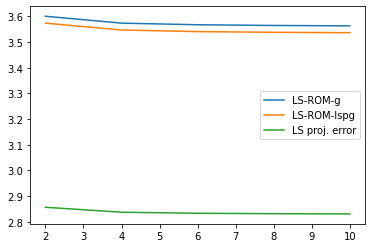

In [5]:
plt.figure()
plt.plot(nparamArr_LSROM,relErr_LSROM_g,nparamArr_LSROM,relErr_LSROM_lspg,nparamArr_LSROM,proErr_LSROM)
plt.legend(['LS-ROM-g','LS-ROM-lspg','LS proj. error'])
plt.show()

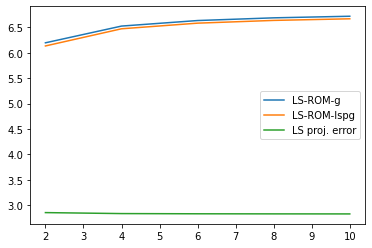

In [6]:
plt.figure()
plt.plot(nparamArr_LSROM,maxErr_LSROM_g,nparamArr_LSROM,maxErr_LSROM_lspg,nparamArr_LSROM,proErr_LSROM)
plt.legend(['LS-ROM-g','LS-ROM-lspg','LS proj. error'])
plt.show()

# Save data to mat file

In [7]:
from scipy.io import savemat, loadmat

In [8]:
dict_err={"relErr_LSROM_g":relErr_LSROM_g,"relErr_LSROM_lspg":relErr_LSROM_lspg,\
          "maxErr_LSROM_g":maxErr_LSROM_g,"maxErr_LSROM_lspg":maxErr_LSROM_lspg,\
          'proErr_LSROM':proErr_LSROM,'nparamArr_LSROM':nparamArr_LSROM}
savemat("./data/LSROM_Err_nparam.mat",dict_err)

pickle.dump(dict_err,open('./data/LSROM_Err_nparam.p','wb'))